In [11]:
%env OPENCV_IO_ENABLE_OPENEXR=1
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from PIL import Image
import torch
import numpy as np
from matplotlib import pyplot as plt
from inference_pytorch import PyTorchPipeline
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
from attack.pytorch_auto_drive.utils.lane_det_utils import lane_as_segmentation_inference
from lanefitting import get_offset_center
from config import *
import logging

logging.getLogger().setLevel(logging.ERROR)

env: OPENCV_IO_ENABLE_OPENEXR=1


In [1]:
from lanefitting import Camera

TARGET=np.load("../attack/targets/turn_right.npy", allow_pickle=True).item()
config_800x288 = {
    'fx': 692.82,
    'fy': 692.82, 
    'px': 400.0, 
    'py': 144.0, 
    'yaw': 90.0, 
    'pitch': 0.0, 
    'roll': 0.0, 
    'XCam': 0.0, 
    'YCam': 0.0, 
    'ZCam': 1.5
}

def inference(pipeline, image, attack=False):
    image_size = image.shape[:2][::-1]
    model_in = image.transpose(2, 0, 1)
    model_in = torch.from_numpy(model_in).unsqueeze(0).to(pipeline.device)
    patch = None

    if attack:
        patch = pipeline.attack.generate(x=model_in.cpu().numpy(), y=TARGET)[0]
        patch_cuda= torch.from_numpy(patch).to(pipeline.device)

        x_1, y_1 = pipeline.patch_location
        x_2, y_2 = x_1 + patch.shape[2], y_1 + patch.shape[1]
        model_in[0][:, y_1:y_2, x_1:x_2] = patch_cuda

        # image with patch: m[0].cpu().numpy()
        # plot image 
        # fig = plt.figure(figsize=(10, 5))
        # ax = fig.add_subplot(1, 1, 1)
        # patched_image = m[0].cpu().numpy().transpose(1, 2, 0)
        # patched_image = cv2.cvtColor(patched_image, cv2.COLOR_BGR2RGB)
        # ax.imshow(patched_image)
        # plt.savefig("attack_input.pdf", format="pdf", bbox_inches="tight")

    results = pipeline.model(model_in)

    keypoints = lane_as_segmentation_inference(
        None,
        results,
        [input_sizes, input_sizes],
        gap,
        ppl,
        thresh,
        dataset,
        max_lane,
        forward=False,  # already called model
    )[0]
    probmaps = get_probmap_images(results, image_size)


    cam = Camera(config_800x288)
    ipm_small = get_ipm_matrix(cam, image)
    offset_center, _, _ = get_offset_center(
        keypoints, (image_size[0], image_size[1]), ipm_small
    )

    return offset_center, probmaps, keypoints, patch


def get_probmap_images(probmaps, image_size):
    prob_maps = torch.nn.functional.interpolate(probmaps['out'], 
                                                size=(image_size[1], image_size[0]), mode='bilinear', align_corners=True)
    prob_maps_softmax = prob_maps.detach().clone().softmax(dim=1)
    
    merged = np.zeros_like(prob_maps[0][1].detach().cpu().numpy())
    merged_softmax = np.zeros_like(prob_maps_softmax[0][1].detach().cpu().numpy())

    for i, lane in enumerate(prob_maps[0]):
        if i == 0: # skip first iteration (background class)
            continue
        pred = lane.detach().cpu().numpy()
        pred_softmax = prob_maps_softmax[0][i].detach().cpu().numpy()
        merged = np.maximum(merged, pred)
        merged_softmax = np.maximum(merged_softmax, pred_softmax)

    im = merged
    im_softmax = merged_softmax

    return im, im_softmax

def get_ipm_matrix(cam, image):
    cam_height = 50.0
    x_offset = 35.0 # in driving direction

    outputRes = (int(2 * cam.config["py"]), int(2 * cam.config["px"]))
    dx = outputRes[1] / cam.config["fx"] * cam_height
    dy = outputRes[0] / cam.config["fy"] * cam_height
    pxPerM = (outputRes[0] / dx, outputRes[1] / dy)


    # setup mapping from street/top-image plane to world coords
    shift = (outputRes[0] / 2.0, outputRes[1] / 2.0) # was (outputRes[0] / 2.0, outputRes[1] / 2.0)
    shift = shift[0] + x_offset * pxPerM[0], shift[1] - cam.config["XCam"] * pxPerM[1]
    M = np.array([[1.0 / pxPerM[1], 0.0, -shift[1] / pxPerM[1]], [0.0, -1.0 / pxPerM[0], shift[0] / pxPerM[0]], [0.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

    ipm = np.linalg.inv(cam.P.dot(M))
    return ipm

ModuleNotFoundError: No module named 'lanefitting'

In [14]:

models = ["resnet50", "erfnet", "resa", "scnn"]
image = cv2.imread("single_frame_eval.exr", cv2.IMREAD_UNCHANGED)

results = {}


for model in models:
    pipeline = PyTorchPipeline(targeted=True, patch_size=(80, 80), 
                               max_iterations=200,
                               model=model)
    
    offset_center, probmaps, keypoints, _ = inference(pipeline, image, attack=False)
    offset_center_attack, probmaps_attack, keypoints_attack, patch = inference(pipeline, image, attack=True)
    print(f"Benign offset center {model}: ", offset_center)
    print(f"Attack offset center {model}: ", offset_center_attack)

    results[model] = {
        "benign": {
            "offset_center": offset_center,
            "probmaps": probmaps,
            "keypoints": keypoints
        },
        "attack": {
            "offset_center": offset_center_attack,
            "probmaps": probmaps_attack,
            "keypoints": keypoints_attack,
            "patch": patch
        }
    }

RobustDPatch iteration: 100%|██████████| 200/200 [00:18<00:00, 10.54it/s, loss=0.2326423] 


Benign offset center resnet50:  0.3509
Attack offset center resnet50:  None


RobustDPatch iteration: 100%|██████████| 200/200 [00:17<00:00, 11.72it/s, loss=0.40677652]


Benign offset center erfnet:  -0.256
Attack offset center erfnet:  37.3025


RobustDPatch iteration: 100%|██████████| 200/200 [00:24<00:00,  8.28it/s, loss=0.31533346]


Benign offset center resa:  -0.4737
Attack offset center resa:  15.3896


RobustDPatch iteration: 100%|██████████| 200/200 [00:58<00:00,  3.44it/s, loss=0.21154071]

Benign offset center scnn:  -0.5643
Attack offset center scnn:  None


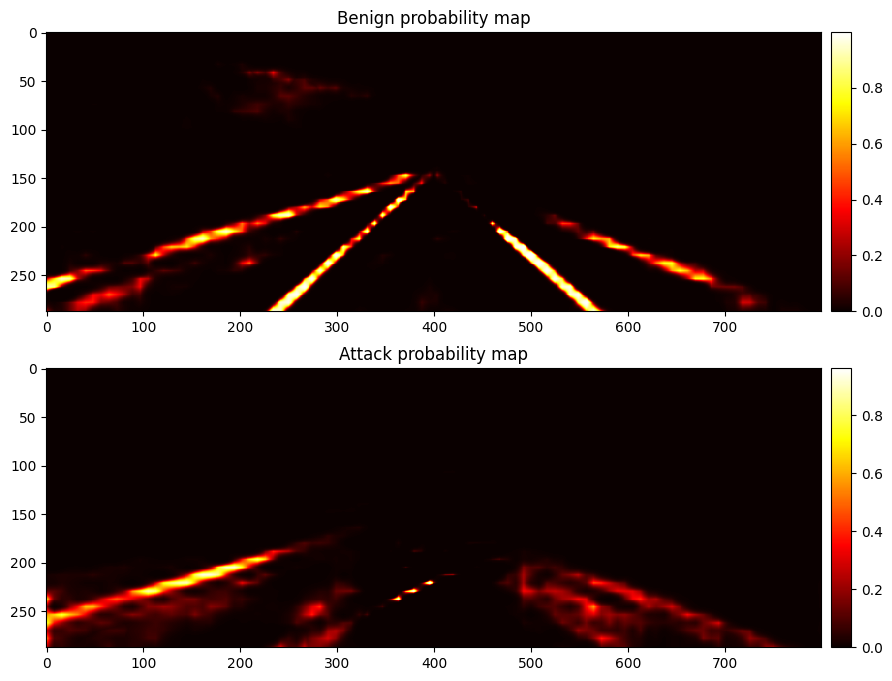

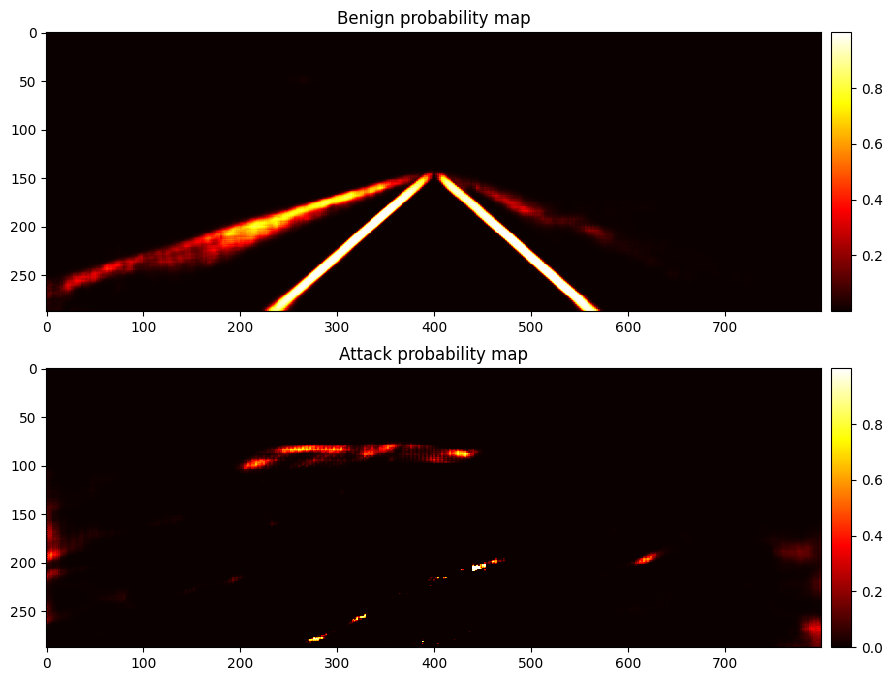

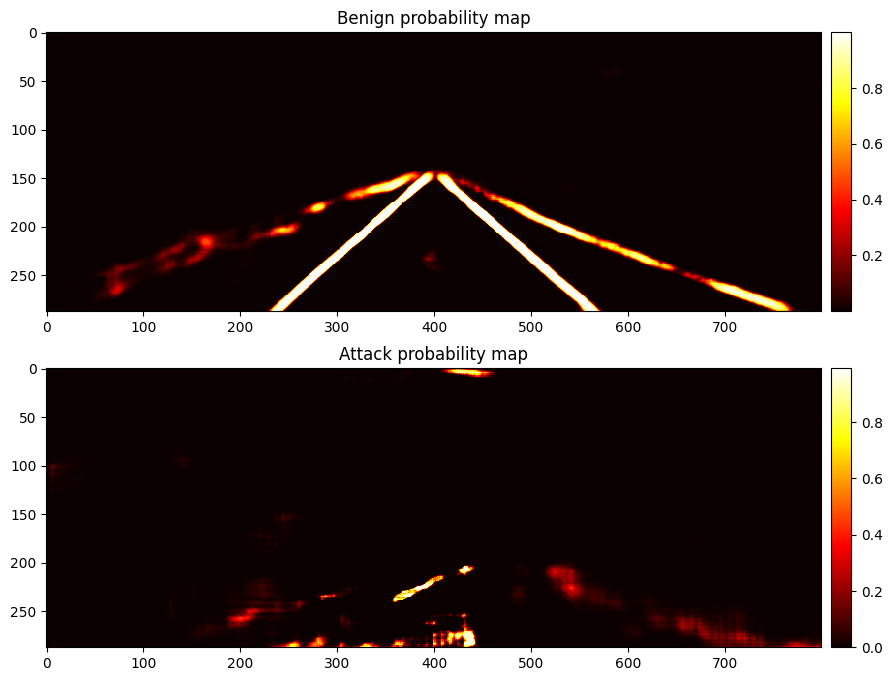

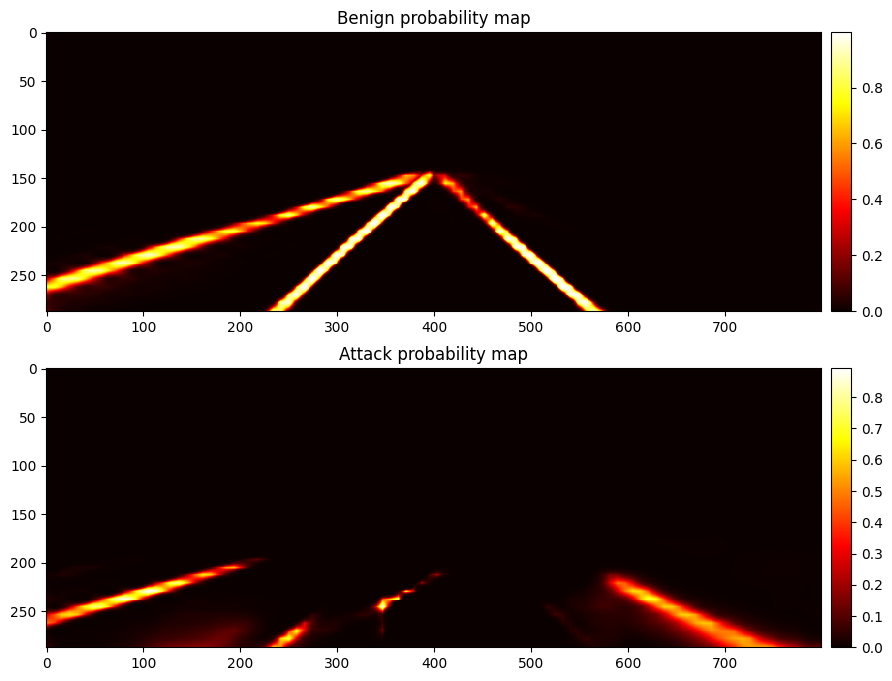

In [ ]:

for name, model in results.items():
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2,1) 
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    img = ax1.imshow(model['benign']['probmaps'][1], cmap='hot',  interpolation='nearest')
    img2 =  ax2.imshow(model['attack']['probmaps'][1], cmap='hot',  interpolation='nearest')

    cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
    cax2 = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])
    plt.colorbar(img, cax=cax)
    plt.colorbar(img2, cax=cax2)

    ax1.title.set_text('Benign probability map')
    ax2.title.set_text('Attack probability map')
    plt.savefig(f"probmaps_attack_{name}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

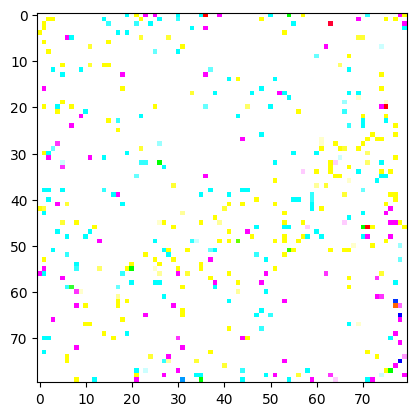

In [17]:
for name, model in results.items():
    plt.imshow(model['attack']['patch'].transpose(1, 2, 0))
    cv2.imwrite(f"patch_{name}.png", model['attack']['patch'].transpose(1, 2, 0) * 255)